In [ ]:
# 1. IMPORTS
import os
import glob
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tifffile import imread

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from google.colab import drive

In [ ]:
# 2. MOUNT DRIVE + UNZIP DATA

drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/02456_DeepLearning/data.zip"
extract_path = "/content/data"

# Unzip only if needed (or overwrite as per original logic)
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_path)
    print("Inside /content/data:", os.listdir("/content/data"))
else:
    print(f"Warning: Zip file not found at {zip_path}")


# 3. DEFINE PATHS & PRELIMINARY CHECKS
root = "/content/data/data"

labeled_images_path    = f"{root}/labeled/images"
labeled_masks_path     = f"{root}/labeled/masks"
unlabeled_images_path  = f"{root}/unlabeled/1h_HT"
unlabeled_cropped_path = f"{root}/unlabeled/1h_HT_cropped"
pseudo_images_path     = f"{root}/pseudo/images"
pseudo_masks_path      = f"{root}/pseudo/masks"

# Create directories
os.makedirs(unlabeled_cropped_path, exist_ok=True)
os.makedirs(pseudo_images_path, exist_ok=True)
os.makedirs(pseudo_masks_path, exist_ok=True)

# Load raw unlabeled images list (needed for processing step)
unlabeled_images_raw = sorted(glob.glob(unlabeled_images_path + "/*.tif"))
print(f"Raw Unlabeled Images found: {len(unlabeled_images_raw)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Inside /content/data: ['pseudo', 'data', 'unlabeled']
Raw Unlabeled Images found: 120


In [ ]:
# 4. PREPROCESSING (CROPPED CLASS)

class SimpleLargeCropPreprocessor:
    def __init__(self, crop_size=750, output_size=256):
        self.crop_size = crop_size
        self.output_size = output_size

    def get_centroid(self, img):
        # Normalize 0-255 for centroid calculation
        if img.dtype != np.uint8:
            img_8u = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        else:
            img_8u = img

        blurred = cv2.GaussianBlur(img_8u, (31, 31), 0)
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        M = cv2.moments(thresh)
        if M["m00"] == 0:
            return None
        return (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

    def process_image(self, img_path):
        try:
            if img_path.lower().endswith(('.tif', '.tiff')):
                img = imread(img_path).astype(np.float32)
            else:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        except Exception as e:
            print(f"Error reading {img_path}: {e}")
            return None, None

        center = self.get_centroid(img)
        if center is None:
            return None, None
        cX, cY = center

        # Crop
        half = self.crop_size // 2
        start_x, start_y = cX - half, cY - half
        end_x, end_y = start_x + self.crop_size, start_y + self.crop_size

        crop = np.zeros((self.crop_size, self.crop_size), dtype=np.float32)

        src_sy, src_ey = max(0, start_y), min(img.shape[0], end_y)
        src_sx, src_ex = max(0, start_x), min(img.shape[1], end_x)
        dst_sy, dst_sx = max(0, -start_y), max(0, -start_x)

        h, w = src_ey - src_sy, src_ex - src_sx
        if h > 0 and w > 0:
            crop[dst_sy:dst_sy + h, dst_sx:dst_sx + w] = img[src_sy:src_ey, src_sx:src_ex]

        # Resize
        final_img = cv2.resize(crop, (self.output_size, self.output_size),
                               interpolation=cv2.INTER_LINEAR)

        # Normalize [0,1]
        if final_img.max() > final_img.min():
            final_img = (final_img - final_img.min()) / (final_img.max() - final_img.min())

        return final_img, center

In [ ]:
# 5. BATCH CROP UNLABELED IMAGES

def batch_process_unlabeled():
    print("Starting batch processing...")

    # Initialize Preprocessor (crop_size=750 as per request)
    preprocessor = SimpleLargeCropPreprocessor(crop_size=750, output_size=256)

    count = 0
    for fpath in unlabeled_images_raw:
        basename = os.path.basename(fpath)

        # Process
        processed_img, center = preprocessor.process_image(fpath)

        if processed_img is None:
            print(f"Warning: Could not process {basename}")
            continue

        # Convert [0,1] float -> [0,255] uint8 for storage
        img_uint8 = (processed_img * 255).astype(np.uint8)

        # Define destinations
        dest_1 = os.path.join(unlabeled_cropped_path, basename)
        dest_2 = os.path.join(pseudo_images_path, basename)

        # Save to both locations
        cv2.imwrite(dest_1, img_uint8)
        cv2.imwrite(dest_2, img_uint8)

        count += 1
        if count % 20 == 0:
            print(f"Processed {count} images...")

    print(f"\nDone! Successfully processed and saved {count} images.")
    print(f"Locations:\n 1. {unlabeled_cropped_path}\n 2. {pseudo_images_path}")

# Execute Batch Processing
if len(unlabeled_images_raw) > 0:
    batch_process_unlabeled()
else:
    print("No unlabeled images found to process.")

Starting batch processing...
Processed 20 images...
Processed 40 images...
Processed 60 images...
Processed 80 images...
Processed 100 images...
Processed 120 images...

Done! Successfully processed and saved 120 images.
Locations:
 1. /content/data/data/unlabeled/1h_HT_cropped
 2. /content/data/data/pseudo/images


In [ ]:
# 6. TRANSFORMS
def normalize_image_transform(img):
    """Normalizes a float PIL image to a [0, 1] tensor."""
    np_img = np.array(img, dtype=np.float32)
    min_val = np.min(np_img)
    max_val = np.max(np_img)

    if max_val - min_val > 1e-6:
        normalized_img = (np_img - min_val) / (max_val - min_val)
    else:
        normalized_img = np.zeros(np_img.shape, dtype=np.float32)

    return torch.from_numpy(normalized_img).unsqueeze(0)

image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(normalize_image_transform)
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda img: torch.from_numpy(np.array(img) <= 0).unsqueeze(0).float())
])

In [ ]:
# 7. DATASETS

class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None, mask_transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform
        self.mask_transform = mask_transform
        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])
        mask  = Image.open(self.mask_files[idx])
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return image, mask

class UnlabeledCroppedDataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

In [ ]:
# 8. LOAD FILE LISTS (LABELED + CROPPED)
labeled_images = sorted(glob.glob(labeled_images_path + "/*.tif"))
labeled_masks  = sorted(glob.glob(labeled_masks_path  + "/*.tif"))
unlabeled_cropped_files = sorted(glob.glob(unlabeled_cropped_path + "/*.tif"))

print(f"\nFinal Data Counts:")
print(f" Labeled Images:        {len(labeled_images)}")
print(f" Labeled Masks:         {len(labeled_masks)}")
print(f" Unlabeled Cropped:     {len(unlabeled_cropped_files)}")

# Instantiate Datasets for Visualization
labeled_dataset = SegmentationDataset(
    image_files=labeled_images,
    mask_files=labeled_masks,
    transform=image_transform,
    mask_transform=mask_transform
)

if len(unlabeled_cropped_files) > 0:
    unlabeled_cropped_dataset = UnlabeledCroppedDataset(
        image_files=unlabeled_cropped_files,
        transform=image_transform
    )
else:
    print("Warning: No cropped images found. Check processing step.")
    unlabeled_cropped_dataset = None


Final Data Counts:
 Labeled Images:        22
 Labeled Masks:         22
 Unlabeled Cropped:     120



9.1 VISUALIZING LABELED DATA


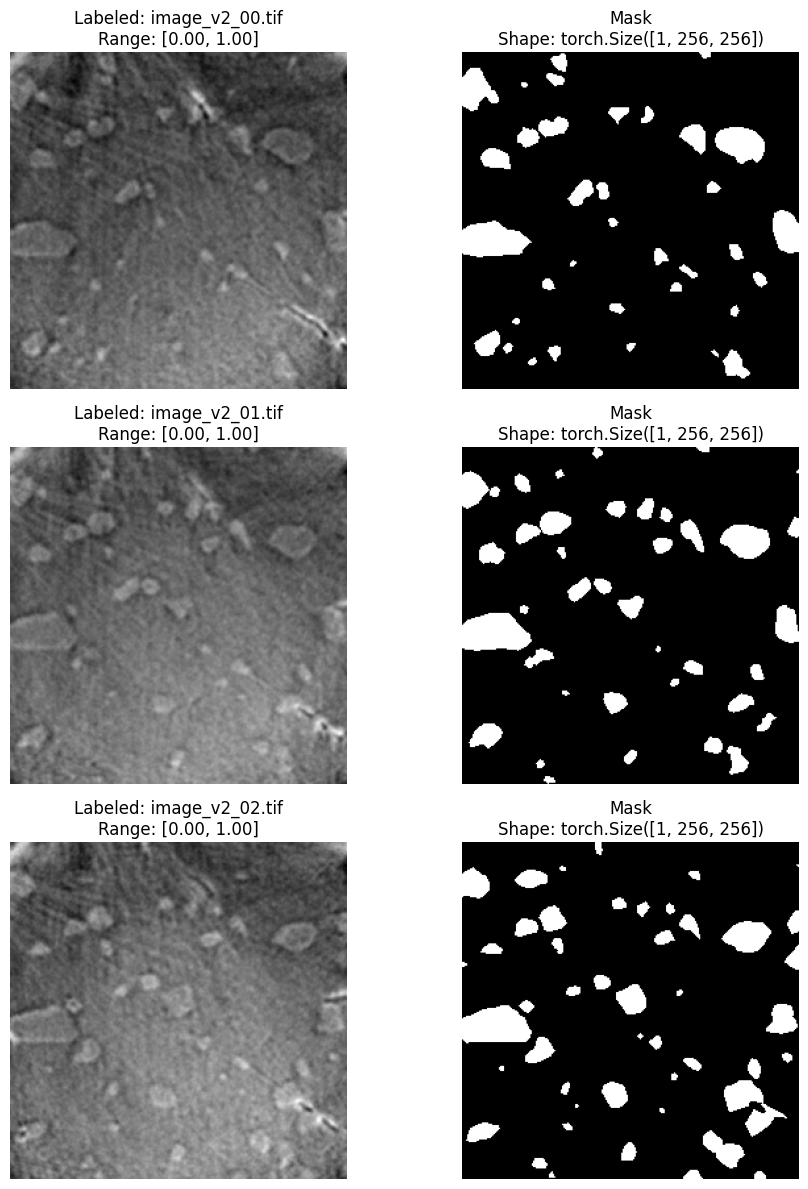

Sample 0 Stats -> Total: 65536, Pores: 6211 (9.48%)

--- 9.2 VISUALIZING UNLABELED RAW (Before Crop) ---


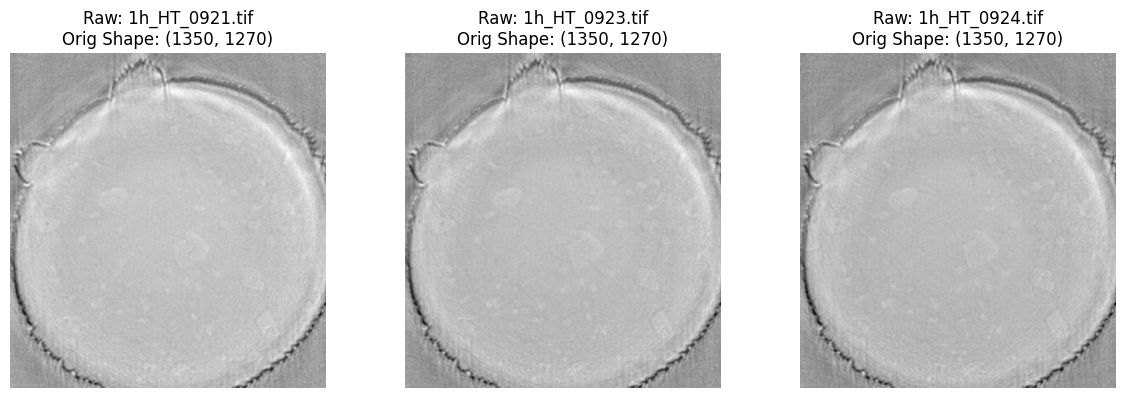


--- 9.3 VISUALIZING UNLABELED CROPPED (Input for Model) ---


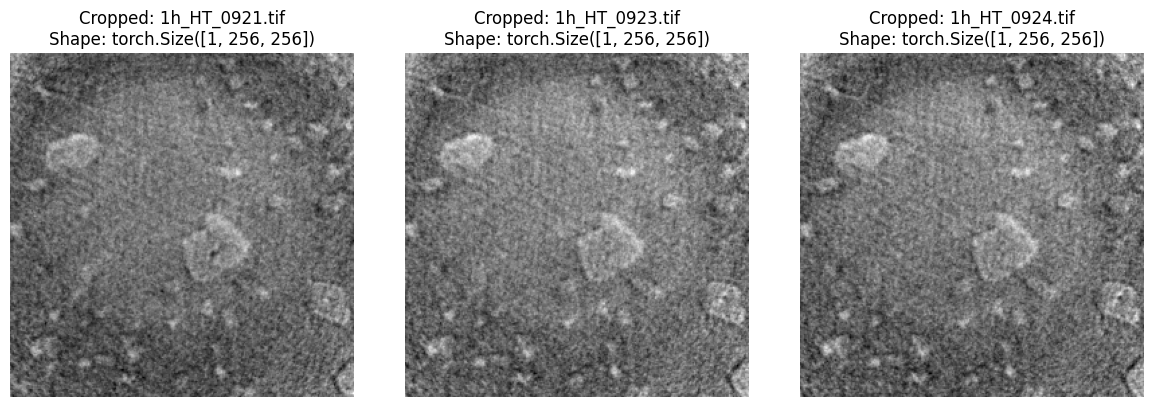

In [ ]:
# 9. QUICK VISUAL CHECKS

# 9.1 Labeled (Image + Mask)
print("\n9.1 VISUALIZING LABELED DATA")
n_samples = 3
plt.figure(figsize=(10, n_samples * 4))

for i in range(min(n_samples, len(labeled_dataset))):
    image_tensor, mask_tensor = labeled_dataset[i]
    fname = os.path.basename(labeled_images[i])

    # Image
    plt.subplot(n_samples, 2, i*2 + 1)
    plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Labeled: {fname}\nRange: [{image_tensor.min():.2f}, {image_tensor.max():.2f}]")
    plt.axis('off')

    # Mask
    plt.subplot(n_samples, 2, i*2 + 2)
    plt.imshow(mask_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Mask\nShape: {mask_tensor.shape}")
    plt.axis('off')
plt.tight_layout()
plt.show()

if len(labeled_dataset) > 0:
    # Stats for Sample 0
    _, mask_t = labeled_dataset[0]
    pore_px = mask_t.sum().item()
    total_px = mask_t.numel()
    print(f"Sample 0 Stats -> Total: {total_px}, Pores: {int(pore_px)} ({pore_px/total_px*100:.2f}%)")

# --- 9.2 Unlabeled Raw ---
print("\n--- 9.2 VISUALIZING UNLABELED RAW (Before Crop) ---")
plt.figure(figsize=(12, 4))
for i in range(min(3, len(unlabeled_images_raw))):
    raw_path = unlabeled_images_raw[i]
    raw_img = imread(raw_path)
    fname = os.path.basename(raw_path)

    plt.subplot(1, 3, i+1)
    plt.imshow(raw_img, cmap='gray')
    plt.title(f"Raw: {fname}\nOrig Shape: {raw_img.shape}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# --- 9.3 Unlabeled Cropped ---
print("\n--- 9.3 VISUALIZING UNLABELED CROPPED (Input for Model) ---")
if unlabeled_cropped_dataset and len(unlabeled_cropped_dataset) > 0:
    plt.figure(figsize=(12, 4))
    for i in range(min(3, len(unlabeled_cropped_dataset))):
        crop_tensor = unlabeled_cropped_dataset[i]
        fname = os.path.basename(unlabeled_cropped_files[i])

        plt.subplot(1, 3, i+1)
        plt.imshow(crop_tensor.squeeze().numpy(), cmap='gray')
        plt.title(f"Cropped: {fname}\nShape: {crop_tensor.shape}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No cropped dataset available to visualize.")

In [ ]:
import random

# 10. DATA LOADING & SPLITTING

# A. Prepare Labeled Data (Train/Val/Test)
full_labeled_dataset = SegmentationDataset(
    labeled_images,
    labeled_masks,
    transform=image_transform,
    mask_transform=mask_transform
)

# Split 80/10/10
# Note: With 22 images, this results in Train: 17, Val: 2, Test: 3
total_count = len(full_labeled_dataset)
train_size = int(0.8 * total_count)
val_size   = int(0.1 * total_count)
test_size  = total_count - train_size - val_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(
    full_labeled_dataset,
    [train_size, val_size, test_size],
    generator=generator
)

# B. Prepare Unlabeled Data (CORRECTION HERE)
# Use 'unlabeled_cropped_files' and 'UnlabeledCroppedDataset'
if len(unlabeled_cropped_files) > 0:
    unlabeled_dataset_full = UnlabeledCroppedDataset(
        unlabeled_cropped_files,
        transform=image_transform
    )
else:
    print("Error: No cropped files found. Did you run the batch processing?")

# C. Create Loaders
# Warning: With only 17 training images, Batch Size 8 results in a last batch of size 1.
# BatchNorm layers will crash with batch_size=1. We set drop_last=True to prevent this.
BATCH_SIZE = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# Loader for generating pseudo-labels (Batch size 1 is safest for generation loops)
unlabeled_loader = DataLoader(unlabeled_dataset_full, batch_size=1, shuffle=False)

print("\nData preparation complete.")
print(f"Train batches: {len(train_loader)} (Batch Size: {BATCH_SIZE})")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")
print(f"Unlabeled images ready: {len(unlabeled_dataset_full)}")


Data preparation complete.
Train batches: 4 (Batch Size: 4)
Val batches:   1
Test batches:  1
Unlabeled images ready: 120


In [ ]:
# 11. LOSS FUNCTION

class CombinedLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, y_true, mu, logvar, beta):
        # 1. Pixel-wise Loss (BCE + Dice)
        # BCE provides stable gradients early on; Dice optimizes the overlap
        bce_loss = self.bce(logits, y_true)

        y_true = y_true.float()
        probs = torch.sigmoid(logits)

        # Flatten for Dice
        inputs = probs.view(probs.shape[0], -1)
        targets = y_true.view(y_true.shape[0], -1)

        intersection = (inputs * targets).sum(dim=1)
        dice = (2. * intersection + self.smooth) / (inputs.sum(dim=1) + targets.sum(dim=1) + self.smooth)
        dice_loss = 1 - dice.mean()

        rec_loss = bce_loss + dice_loss

        # 2. KL Divergence
        # Clamp logvar to prevent NaN in exp()
        logvar = torch.clamp(logvar, min=-10, max=10)
        # Sum over latent dim, mean over batch
        kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

        # 3. Total
        # We scale KL by a small factor because reconstruction loss is ~1.0,
        # while raw KL can be huge.
        total_loss = rec_loss + (beta * kl_loss)

        return total_loss, rec_loss, kl_loss

In [ ]:
# 12. MODELS

import torch
import torch.nn as nn
import torch.nn.functional as F

# 1) DoubleConv

class DoubleConv(nn.Module):
    """(Conv → BatchNorm → ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

# 2) Split UNet into Encoder + Decoder

class UNetEncoder(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # Match these channel sizes to your original UNet
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck_conv = DoubleConv(512, 1024)  # this is your original bottleneck

    def forward(self, x):
        e1 = self.enc1(x)               # [B,  64, H,   W  ]
        e2 = self.enc2(self.pool1(e1))  # [B, 128, H/2, W/2]
        e3 = self.enc3(self.pool2(e2))  # [B, 256, H/4, W/4]
        e4 = self.enc4(self.pool3(e3))  # [B, 512, H/8, W/8]
        b  = self.bottleneck_conv(self.pool4(e4))  # [B,1024,H/16,W/16]
        return e1, e2, e3, e4, b


class UNetDecoder(nn.Module):
    def __init__(self, out_channels=1):
        super().__init__()

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4    = DoubleConv(512 + 512, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3    = DoubleConv(256 + 256, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2    = DoubleConv(128 + 128, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1    = DoubleConv(64 + 64, 64)

        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, z_feat, e1, e2, e3, e4):
        # z_feat replaces the old "b" at the bottom of the UNet
        d4 = self.upconv4(z_feat)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        out = self.output_conv(d1)
        return out


# 3) VAE Bottlenec

class VAEBottleneck(nn.Module):
    def __init__(self, in_channels=1024, z_dim=32):
        super().__init__()

        # 1. Downsample spatially to reduce parameters
        # Input: [B, 1024, 16, 16]
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, padding=1),   # [B, 256, 16, 16]
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 128, 3, stride=2, padding=1), # [B, 128, 8, 8]
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, stride=2, padding=1), # [B, 128, 4, 4]
            nn.BatchNorm2d(128), nn.ReLU(),
        )

        # 128 channels * 4 * 4 = 2048 features.
        # This is safe for a Linear layer.
        self.flat_dim = 128 * 4 * 4

        # 2. VAE Stats
        self.fc_mu = nn.Linear(self.flat_dim, z_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, z_dim)
        self.fc_decode = nn.Linear(z_dim, self.flat_dim)

        # 3. Upsample back to bottleneck size
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1), # [B, 128, 8, 8]
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 256, 3, stride=2, padding=1, output_padding=1), # [B, 256, 16, 16]
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, in_channels, 3, padding=1), # [B, 1024, 16, 16]
            nn.BatchNorm2d(in_channels), nn.ReLU(),
        )

    def forward(self, x):
        # x: [B, 1024, 16, 16]
        enc = self.encoder_conv(x)
        B, C, H, W = enc.shape

        flat = enc.view(B, -1)
        mu = self.fc_mu(flat)
        logvar = self.fc_logvar(flat)

        # Reparameterize
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std

        # Decode
        dec_flat = self.fc_decode(z)
        dec_view = dec_flat.view(B, C, H, W)
        out = self.decoder_conv(dec_view) # [B, 1024, 16, 16]

        return out, mu, logvar

class SkipVAEUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, z_dim=32):
        super().__init__()
        self.encoder = UNetEncoder(in_channels)
        self.bottleneck = VAEBottleneck(in_channels=1024, z_dim=z_dim)
        self.decoder = UNetDecoder(out_channels)

    def forward(self, x):
        e1, e2, e3, e4, b = self.encoder(x)
        z_feat, mu, logvar = self.bottleneck(b)
        logits = self.decoder(z_feat, e1, e2, e3, e4)
        return logits, mu, logvar

In [ ]:
# 3. TEACHER TRAINING LOOP
# (Standard Supervised Training on 'train_loader')

import random
import numpy as np
import torch
import torch.optim as optim
from time import time

SEED = 42
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)
print(f"Reproducibility seed set to {SEED}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Model
model = SkipVAEUNet(in_channels=1, out_channels=1, z_dim=32).to(device)

learning_rate = 1e-4
opt = optim.Adam(model.parameters(), learning_rate)
criterion = CombinedLoss(smooth=1.0)

epochs = 50
kl_scale = 0.01

train_losses = []
val_losses = []

print("\nStarting Teacher Training (Labeled Data Only)...")

for epoch in range(epochs):
    tic = time()
    anneal_factor = min(1.0, epoch / (epochs / 2))
    beta = anneal_factor * kl_scale

    # Training Phase
    model.train()
    avg_rec_loss = 0.0
    avg_kl = 0.0

    # Note: 'train_loader' is already defined from previous data prep step
    for X_batch, y_true in train_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        opt.zero_grad()
        logits, mu, logvar = model(X_batch)
        loss, rec_loss, kl_loss_val = criterion(logits, y_true, mu, logvar, beta)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        opt.step()

        avg_rec_loss += rec_loss.item() / len(train_loader)
        avg_kl       += kl_loss_val.item() / len(train_loader)

    # Validation Phase
    model.eval()
    avg_val_rec = 0.0
    avg_val_kl = 0.0

    with torch.no_grad():
        for X_batch, y_true in val_loader:
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)
            logits, mu, logvar = model(X_batch)
            loss, rec_loss, kl_loss_val = criterion(logits, y_true, mu, logvar, beta)

            avg_val_rec += rec_loss.item() / len(val_loader)
            avg_val_kl  += kl_loss_val.item() / len(val_loader)

    toc = time()
    train_losses.append(avg_rec_loss + beta * avg_kl)
    val_losses.append(avg_val_rec + beta * avg_val_kl)

    if (epoch+1) % 5 == 0:
        print(f'* Epoch {epoch+1:02d}/{epochs} (beta={beta:.5f})')
        print(f'  - Train Total: {avg_rec_loss + beta*avg_kl:.4f}')
        print(f'  - Val Total:   {avg_val_rec + beta*avg_val_kl:.4f}')

print("\nTeacher training finished!")

# SAVE THE TEACHER MODEL
torch.save(model.state_dict(), "teacher_skip_vae.pth")
print("Teacher weights saved to 'teacher_skip_vae.pth'")

Reproducibility seed set to 42
Using device: cuda

Starting Teacher Training (Labeled Data Only)...
* Epoch 05/50 (beta=0.00160)
  - Train Total: 0.9787
  - Val Total:   1.2653
* Epoch 10/50 (beta=0.00360)
  - Train Total: 0.7873
  - Val Total:   1.0192
* Epoch 15/50 (beta=0.00560)
  - Train Total: 0.6912
  - Val Total:   0.7952
* Epoch 20/50 (beta=0.00760)
  - Train Total: 0.6321
  - Val Total:   0.6616
* Epoch 25/50 (beta=0.00960)
  - Train Total: 0.5843
  - Val Total:   0.6538
* Epoch 30/50 (beta=0.01000)
  - Train Total: 0.5473
  - Val Total:   0.6357
* Epoch 35/50 (beta=0.01000)
  - Train Total: 0.5062
  - Val Total:   0.5954
* Epoch 40/50 (beta=0.01000)
  - Train Total: 0.4836
  - Val Total:   0.5794
* Epoch 45/50 (beta=0.01000)
  - Train Total: 0.4607
  - Val Total:   0.5732
* Epoch 50/50 (beta=0.01000)
  - Train Total: 0.4362
  - Val Total:   0.5556

Teacher training finished!
Teacher weights saved to 'teacher_skip_vae.pth'


Loaded weights from 'teacher_skip_vae.pth' for evaluation.

Evaluating on 3 test images...

--- Test Results ---
Average Dice Score: 0.8126
Average IoU Score:  0.6844


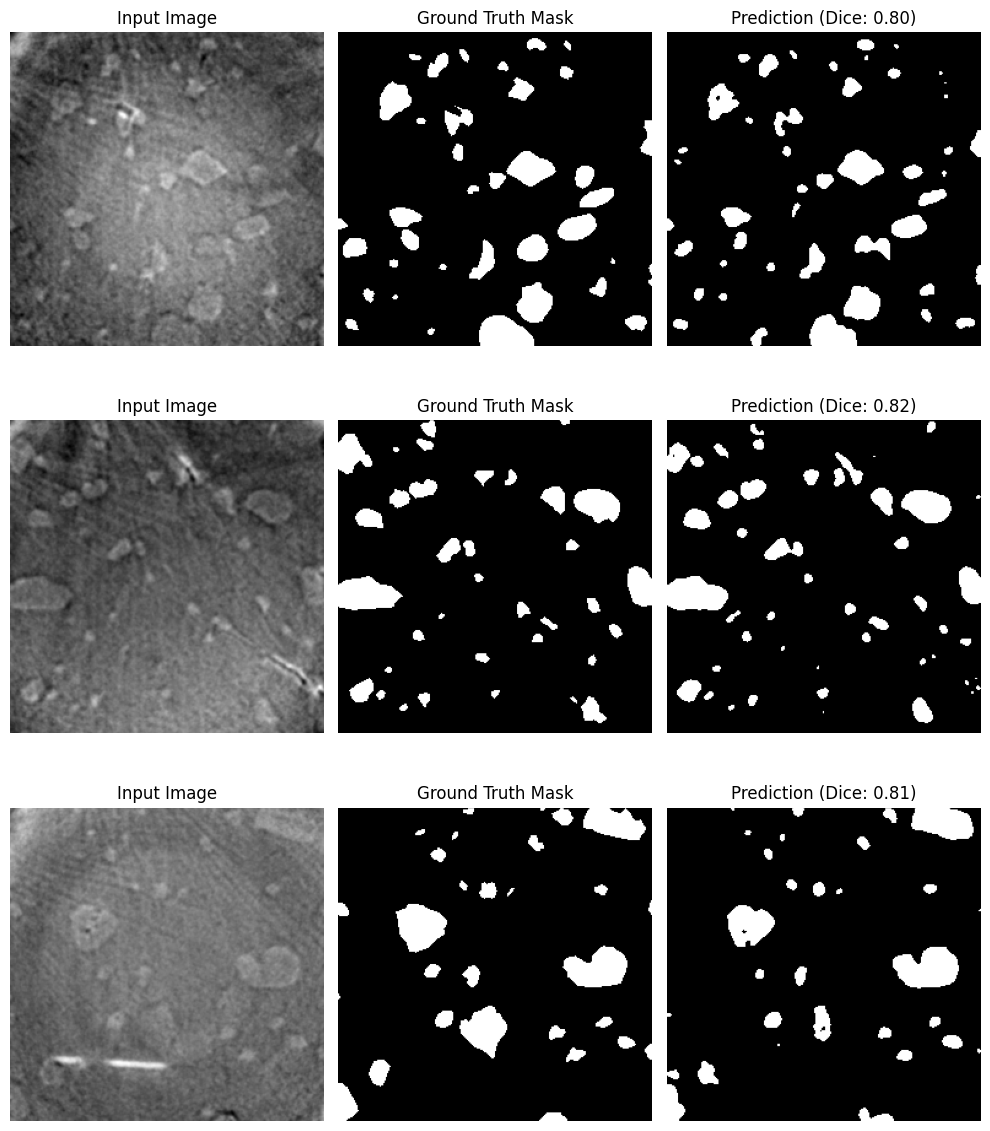

In [ ]:
# EVALUATE TEACHER ON TEST SET

def evaluate_and_visualize(model, loader, device='cuda', threshold=0.5):
    model.eval()
    model.to(device)

    # 1. Load the best weights
    # Ensure the file path matches where you saved it
    weights_path = "teacher_skip_vae.pth"
    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path))
        print(f"Loaded weights from '{weights_path}' for evaluation.")
    else:
        print(f"Warning: '{weights_path}' not found. Using current model weights.")

    dice_scores = []
    iou_scores = []

    # Lists to store samples for visualization
    vis_images = []
    vis_masks = []
    vis_preds = []

    print(f"\nEvaluating on {len(loader.dataset)} test images...")

    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            images = images.to(device)
            masks = masks.to(device)

            # 2. Forward Pass
            # We ignore mu and logvar during evaluation
            logits, _, _ = model(images)

            # Apply Sigmoid to get probabilities [0,1]
            probs = torch.sigmoid(logits)

            # Threshold to get binary mask {0,1}
            preds = (probs > threshold).float()

            # 3. Calculate Metrics per Sample
            for j in range(images.size(0)):
                # Flatten single image/mask for metric calc
                p_flat = preds[j].view(-1)
                m_flat = masks[j].view(-1)

                intersection = (p_flat * m_flat).sum().item()
                p_sum = p_flat.sum().item()
                m_sum = m_flat.sum().item()

                # Dice Score: 2*Inter / (Sum_Pred + Sum_GT)
                dice = (2. * intersection) / (p_sum + m_sum + 1e-6)
                dice_scores.append(dice)

                # IoU Score: Inter / (Union)
                # Union = Sum_Pred + Sum_GT - Inter
                union = p_sum + m_sum - intersection
                iou = intersection / (union + 1e-6)
                iou_scores.append(iou)

                # Save first 3 samples for visualization
                if len(vis_images) < 3:
                    vis_images.append(images[j].cpu())
                    vis_masks.append(masks[j].cpu())
                    vis_preds.append(preds[j].cpu())

    avg_dice = np.mean(dice_scores)
    avg_iou = np.mean(iou_scores)

    print(f"\n--- Test Results ---")
    print(f"Average Dice Score: {avg_dice:.4f}")
    print(f"Average IoU Score:  {avg_iou:.4f}")

    # 4. Visualization
    n_plot = len(vis_images)
    plt.figure(figsize=(10, 4 * n_plot))

    for k in range(n_plot):
        # Image (Convert to numpy)
        plt.subplot(n_plot, 3, k*3 + 1)
        plt.imshow(vis_images[k].squeeze().numpy(), cmap='gray')
        plt.title("Input Image")
        plt.axis('off')

        # Ground Truth (Convert to numpy)
        plt.subplot(n_plot, 3, k*3 + 2)
        plt.imshow(vis_masks[k].squeeze().numpy(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Prediction (Convert to numpy)
        plt.subplot(n_plot, 3, k*3 + 3)
        plt.imshow(vis_preds[k].squeeze().numpy(), cmap='gray')
        # Use the specific dice score for this sample
        # Since we stored samples sequentially, indices match
        plt.title(f"Prediction (Dice: {dice_scores[k]:.2f})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run Evaluation
# Ensure 'model' is initialized and 'test_loader' is available
evaluate_and_visualize(model, test_loader, device=device)

# **PSEUDO LABELING**

In [ ]:

# PSEUDO-LABEL GENERATION
import shutil
import torch
import numpy as np
import os
from PIL import Image
from torch.utils.data import DataLoader, Dataset

# A. Define a specific dataset just for this step
# We use a new name so we don't break the original 'UnlabeledCroppedDataset'
class NamedDataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        filename = os.path.basename(img_path)
        # Returns image AND metadata
        return image, filename, img_path

# B. Setup Generation Loader
# We use the file list 'unlabeled_cropped_files' created in earlier steps
if len(unlabeled_cropped_files) > 0:
    gen_dataset = NamedDataset(unlabeled_cropped_files, transform=image_transform)
    # Batch size MUST be 1 to handle filenames easily
    gen_loader = DataLoader(gen_dataset, batch_size=1, shuffle=False)
else:
    print("Error: No cropped files found. Please run the Batch Processing step.")
    gen_loader = None

# C. Generation Function
def generate_pseudo_labels(model, dataloader, save_img_dir, save_mask_dir, device='cuda'):
    model.eval()
    model.to(device)

    # 1. Clean directories (Ensure 1:1 pairs)
    print("Cleaning pseudo-label directories...")
    if os.path.exists(save_img_dir): shutil.rmtree(save_img_dir)
    if os.path.exists(save_mask_dir): shutil.rmtree(save_mask_dir)
    os.makedirs(save_img_dir, exist_ok=True)
    os.makedirs(save_mask_dir, exist_ok=True)

    # 2. Load Teacher Weights
    weights_path = "teacher_skip_vae.pth"
    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path))
        print(f"Loaded teacher weights from {weights_path}")
    else:
        print("Warning: Weights file not found! Using current model state.")

    print(f"Processing {len(dataloader)} images...")

    count = 0
    skipped_low_conf = 0
    skipped_empty = 0

    with torch.no_grad():
        for image_tensor, filename, original_path in dataloader:
            image_tensor = image_tensor.to(device)
            fname = filename[0]      # Unpack list from batch_size=1
            src_path = original_path[0]

            # Forward Pass
            logits, _, _ = model(image_tensor)
            probs = torch.sigmoid(logits)

            # Confidence Check (>80% confidence on at least one pixel)
            if probs.max() < 0.6:
                skipped_low_conf += 1
                continue

            # Thresholding
            pred_mask = (probs > 0.3).float()

            # Empty Check (Skip if mask has fewer than 5 pixels)
            if pred_mask.sum() < 5:
                skipped_empty += 1
                continue

            # Save Mask
            mask_np = pred_mask.squeeze().cpu().numpy()
            mask_uint8 = (mask_np * 255).astype(np.uint8)

            mask_save_path = os.path.join(save_mask_dir, fname)
            Image.fromarray(mask_uint8).save(mask_save_path)

            # Save Image (Copy from source to keep pairs synced)
            shutil.copy(src_path, os.path.join(save_img_dir, fname))

            count += 1
            if count % 20 == 0:
                print(f"Generated {count} pairs...")

    print(f"\nGeneration Complete:")
    print(f" - Accepted High-Conf Pairs: {count}")
    print(f" - Skipped (Low Confidence): {skipped_low_conf}")
    print(f" - Skipped (Empty Mask):     {skipped_empty}")
    print(f" - Output: {save_img_dir}")

# D. Run It
# Define paths (from previous setup)
pseudo_images_path = f"{root}/pseudo/images"
pseudo_masks_path  = f"{root}/pseudo/masks"

if gen_loader:
    generate_pseudo_labels(model, gen_loader, pseudo_images_path, pseudo_masks_path, device=device)

Cleaning pseudo-label directories...
Loaded teacher weights from teacher_skip_vae.pth
Processing 120 images...
Generated 20 pairs...
Generated 40 pairs...
Generated 60 pairs...
Generated 80 pairs...
Generated 100 pairs...
Generated 120 pairs...

Generation Complete:
 - Accepted High-Conf Pairs: 120
 - Skipped (Low Confidence): 0
 - Skipped (Empty Mask):     0
 - Output: /content/data/data/pseudo/images


Found 120 pseudo-labeled pairs. Showing 5 random samples...


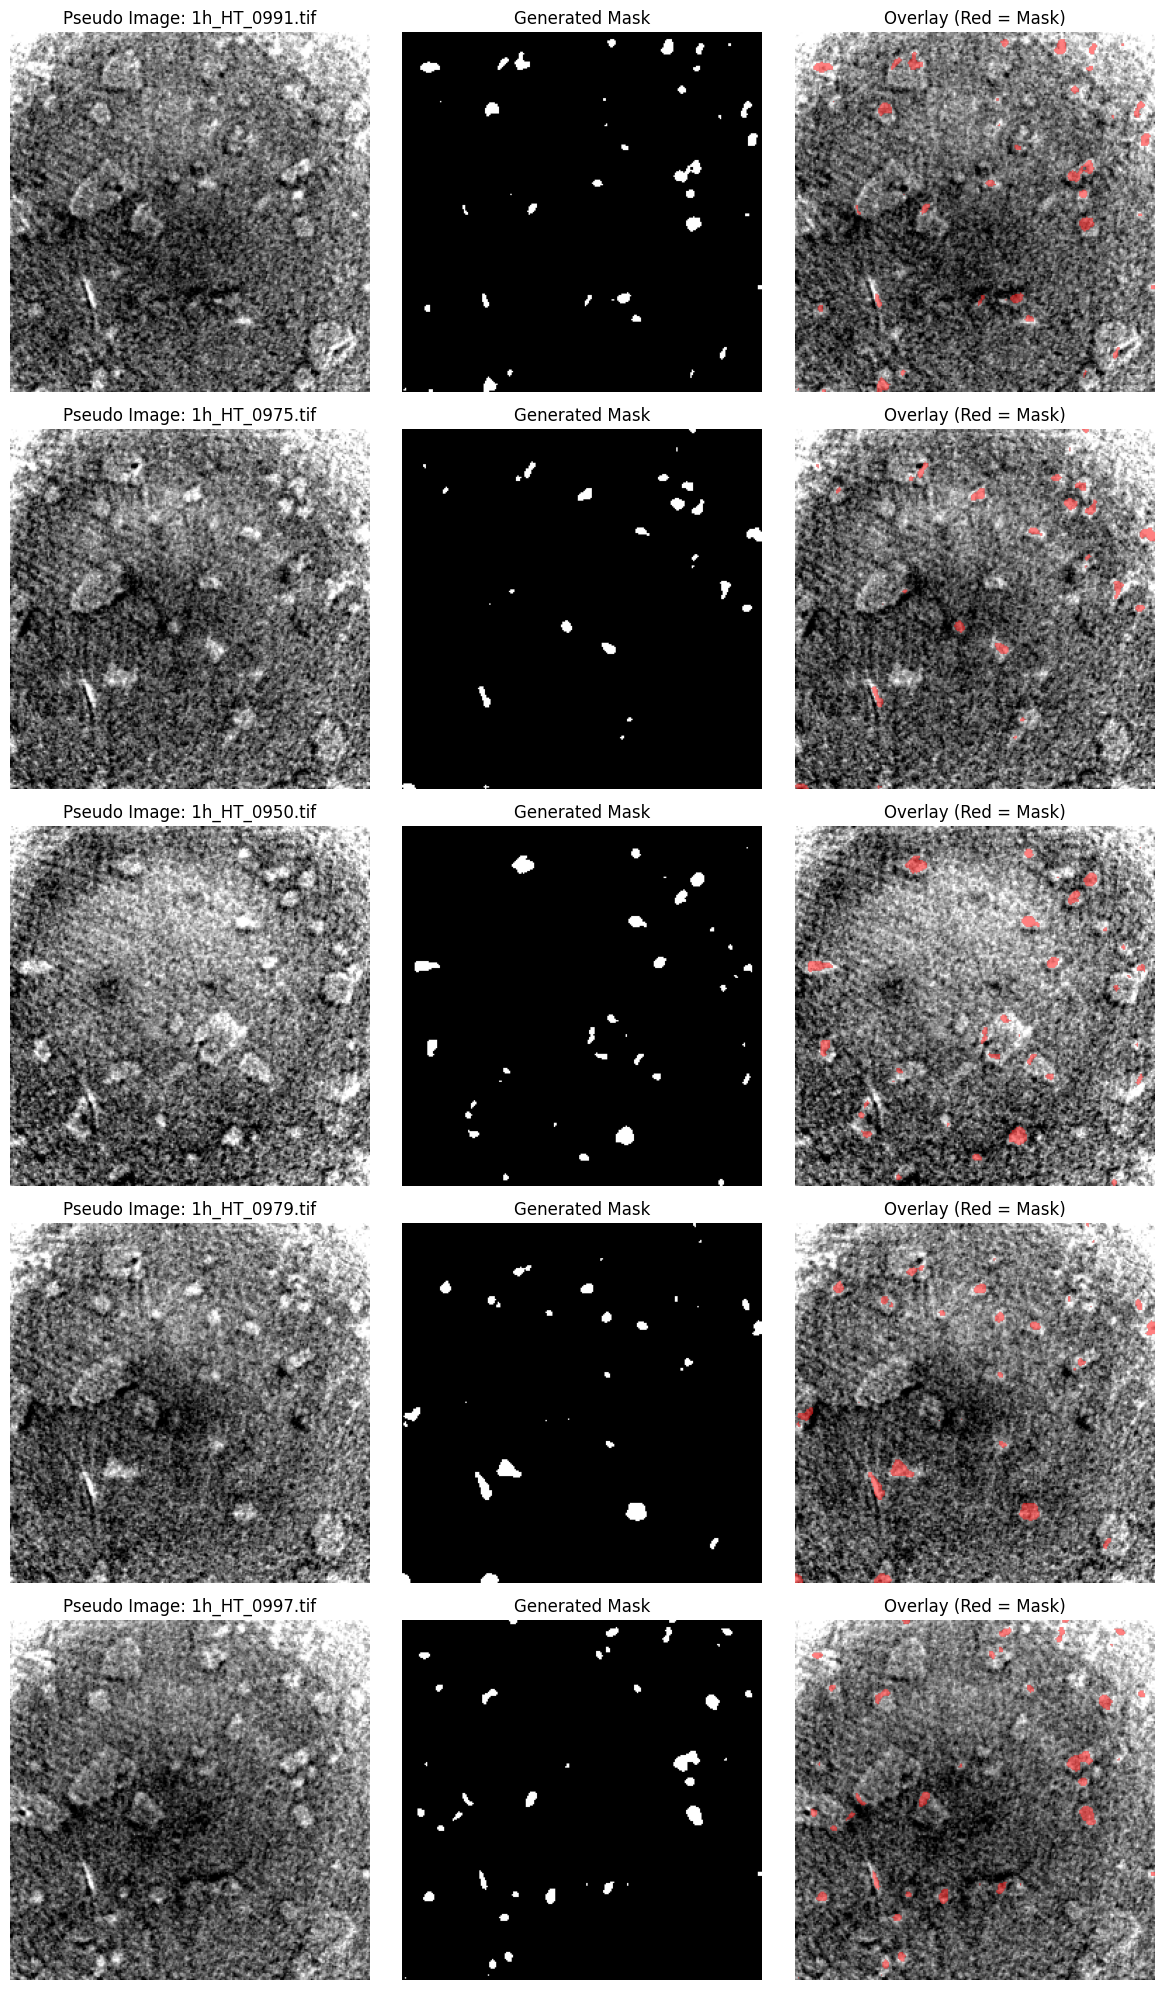

In [ ]:
import matplotlib.pyplot as plt
import random
import glob
import os
import numpy as np
from PIL import Image
import cv2  # <--- Using OpenCV instead of tifffile for this step

# ==========================================
# VISUALIZE PSEUDO-LABEL QUALITY (Fixed)
# ==========================================

def visualize_generated_pseudo_labels(num_samples=5):
    # 1. Define paths
    root = "/content/data/data"
    pseudo_img_dir = f"{root}/pseudo/images"
    pseudo_mask_dir = f"{root}/pseudo/masks"

    # 2. Get file lists
    img_files = sorted(glob.glob(os.path.join(pseudo_img_dir, "*.tif")))
    mask_files = sorted(glob.glob(os.path.join(pseudo_mask_dir, "*.tif")))

    # 3. Safety Check
    if len(img_files) == 0:
        print(f"No pseudo-labels found in {pseudo_img_dir}!")
        return

    n_plot = min(len(img_files), num_samples)
    print(f"Found {len(img_files)} pseudo-labeled pairs. Showing {n_plot} random samples...")

    indices = random.sample(range(len(img_files)), n_plot)

    plt.figure(figsize=(12, 4 * len(indices)))

    for i, idx in enumerate(indices):
        img_path = img_files[idx]
        mask_path = mask_files[idx]
        fname = os.path.basename(img_path)

        # --- FIX: Use cv2 instead of tifffile ---
        # IMREAD_UNCHANGED ensures we read the raw values (whether 8-bit or 16-bit)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED).astype(np.float32)

        # Load Mask
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # --- ROBUST NORMALIZATION ---
        p2, p98 = np.percentile(img, (2, 98))
        if p98 - p2 > 1e-6:
            img_disp = (np.clip(img, p2, p98) - p2) / (p98 - p2)
        else:
            img_disp = img

        # 1. Image
        plt.subplot(len(indices), 3, i*3 + 1)
        plt.imshow(img_disp, cmap='gray')
        plt.title(f"Pseudo Image: {fname}")
        plt.axis('off')

        # 2. Mask
        plt.subplot(len(indices), 3, i*3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Generated Mask")
        plt.axis('off')

        # 3. Overlay
        plt.subplot(len(indices), 3, i*3 + 3)
        plt.imshow(img_disp, cmap='gray')
        masked_mask = np.ma.masked_where(mask == 0, mask)
        plt.imshow(masked_mask, cmap='autumn', alpha=0.5)
        plt.title("Overlay (Red = Mask)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run
visualize_generated_pseudo_labels(num_samples=5)

Found 120 pseudo-labeled pairs. Showing 5 random samples...


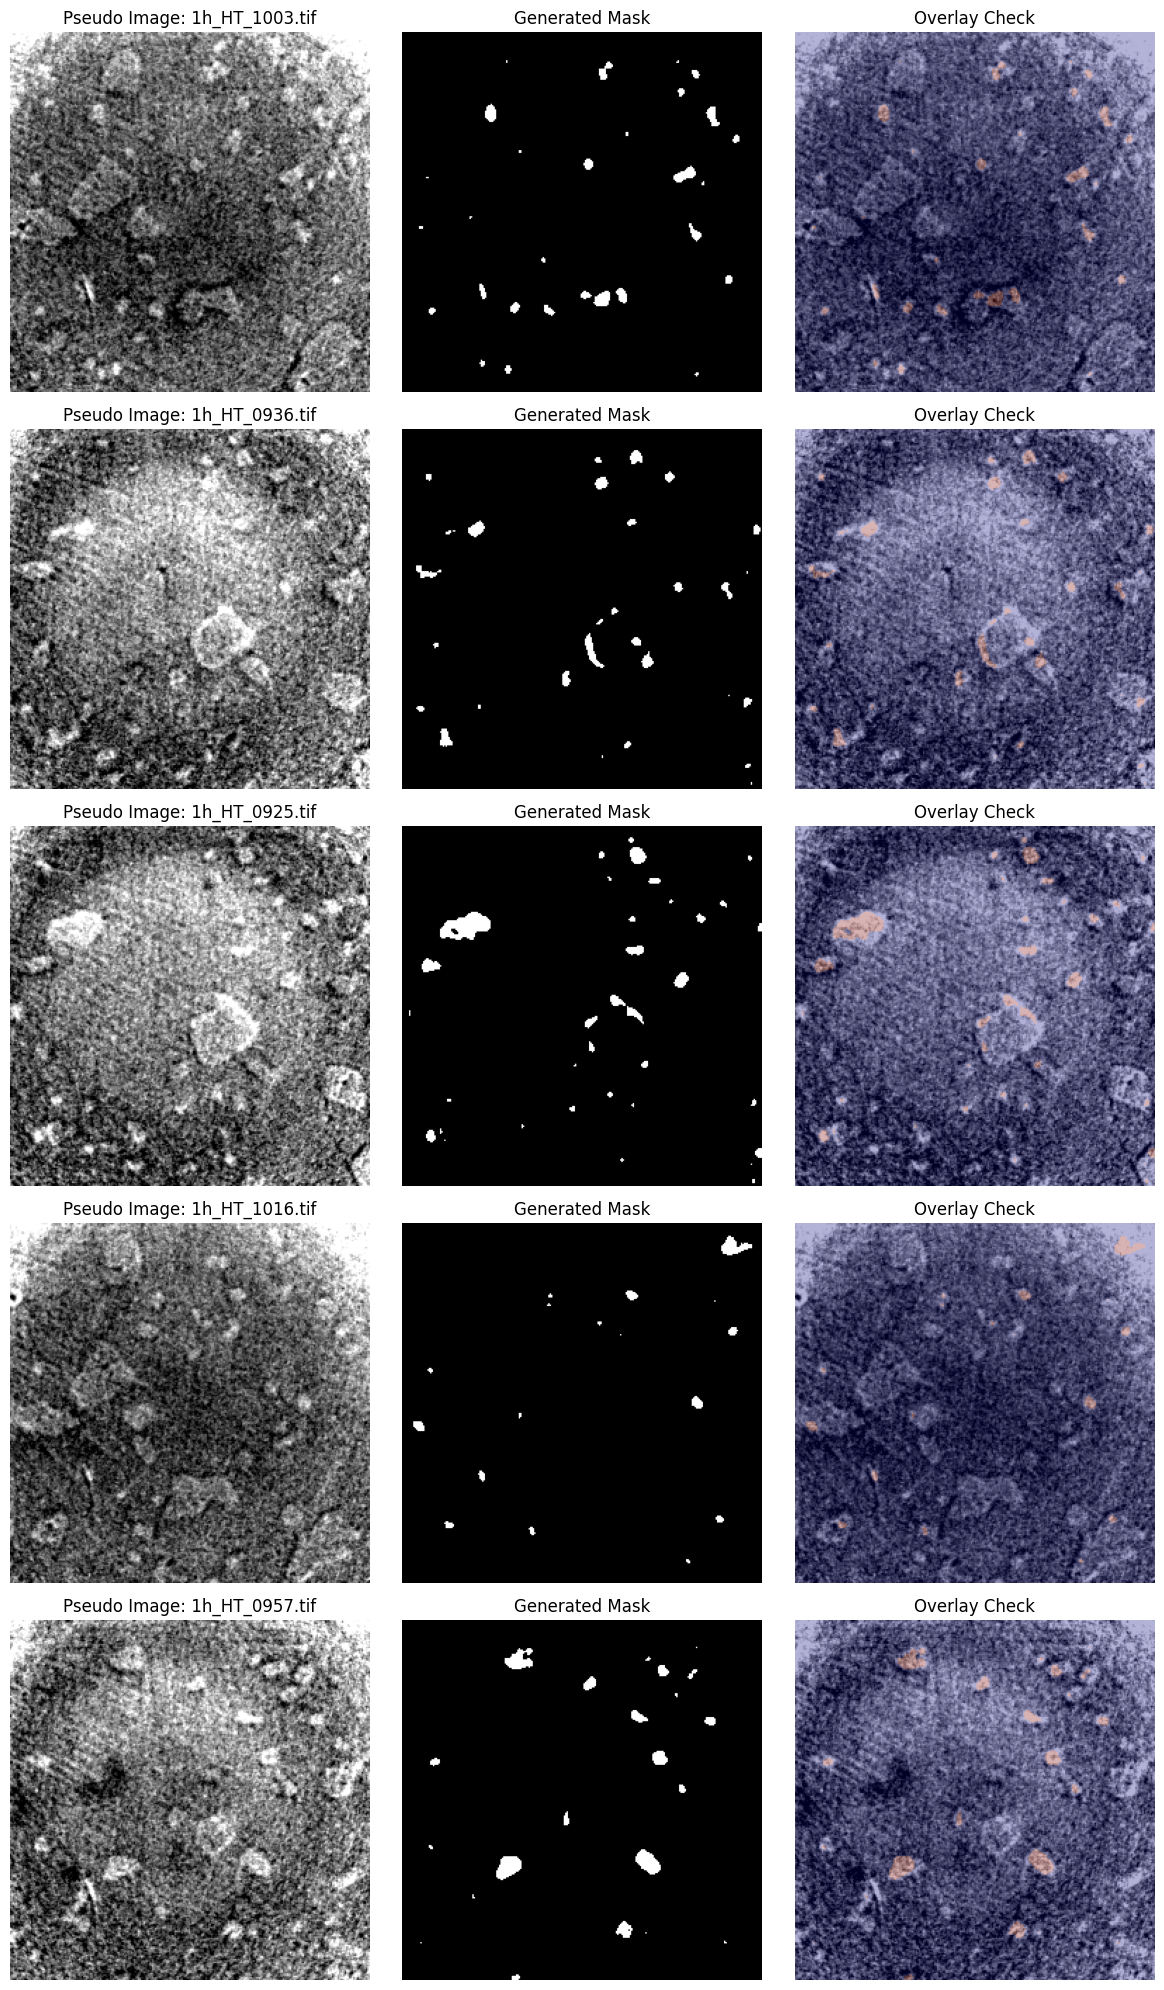

In [ ]:
import matplotlib.pyplot as plt
import random
import glob
import os
import numpy as np
from PIL import Image
from tifffile import imread

# ==========================================
# VISUALIZE PSEUDO-LABEL QUALITY
# ==========================================

def visualize_generated_pseudo_labels(num_samples=5):
    # Define paths (must match the ones in your Master Script)
    root = "/content/data"
    pseudo_img_dir = f"{root}/pseudo/images"
    pseudo_mask_dir = f"{root}/pseudo/masks"

    # Get file lists
    img_files = sorted(glob.glob(os.path.join(pseudo_img_dir, "*.tif")))
    mask_files = sorted(glob.glob(os.path.join(pseudo_mask_dir, "*.tif")))

    # Safety Check
    if len(img_files) == 0:
        print(f"No pseudo-labels found in {pseudo_img_dir}!")
        print("Did you run Step 5 (Generation) in the code above?")
        return

    print(f"Found {len(img_files)} pseudo-labeled pairs. Showing {num_samples} random samples...")

    # Pick random samples
    indices = random.sample(range(len(img_files)), min(len(img_files), num_samples))

    plt.figure(figsize=(12, 4 * len(indices)))

    for i, idx in enumerate(indices):
        img_path = img_files[idx]
        mask_path = mask_files[idx]
        fname = os.path.basename(img_path)

        # Load
        # Load image as float for better contrast scaling
        img = imread(img_path).astype(np.float32)
        mask = Image.open(mask_path)
        mask = np.array(mask)

        # --- ROBUST NORMALIZATION FOR DISPLAY ---
        # (This fixes the "black image" issue for visualization)
        p2, p98 = np.percentile(img, (2, 98))
        if p98 - p2 > 1e-6:
            img_disp = (np.clip(img, p2, p98) - p2) / (p98 - p2)
        else:
            img_disp = img

        # 1. Image
        plt.subplot(len(indices), 3, i*3 + 1)
        plt.imshow(img_disp, cmap='gray')
        plt.title(f"Pseudo Image: {fname}")
        plt.axis('off')

        # 2. Mask
        plt.subplot(len(indices), 3, i*3 + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Generated Mask")
        plt.axis('off')

        # 3. Overlay (Red = Mask)
        plt.subplot(len(indices), 3, i*3 + 3)
        plt.imshow(img_disp, cmap='gray')
        plt.imshow(mask, cmap='jet', alpha=0.3) # Alpha blends mask over image
        plt.title("Overlay Check")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run
visualize_generated_pseudo_labels(num_samples=5)

In [ ]:
# ==========================================
# 6. STUDENT TRAINING (SEMI-SUPERVISED)
# ==========================================
print("\n--- Step 5: Training Student Model (Semi-Supervised) ---")

# Setup Student Datasets
pseudo_files = sorted(glob.glob(f"{pseudo_images_path}/*.tif"))
pseudo_masks = sorted(glob.glob(f"{pseudo_masks_path}/*.tif"))

if len(pseudo_files) > 0:
    pseudo_dataset = SegmentationDataset(pseudo_files, pseudo_masks, image_transform, mask_transform)

    # Dual Loaders (50/50 split)
    loader_l = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
    loader_p = DataLoader(pseudo_dataset, batch_size=4, shuffle=True, drop_last=True)

    # Initialize Student
    student = SkipVAEUNet(in_channels=1, out_channels=1, z_dim=32).to(device)
    opt_s = optim.Adam(student.parameters(), lr=1e-4)

    for epoch in range(50):
        student.train()
        total_loss = 0
        steps = 0
        iter_l = iter(loader_l)

        for p_img, p_mask in loader_p:
            try:
                l_img, l_mask = next(iter_l)
            except StopIteration:
                iter_l = iter(loader_l)
                l_img, l_mask = next(iter_l)

            l_img, l_mask = l_img.to(device), l_mask.to(device)
            p_img, p_mask = p_img.to(device), p_mask.to(device)

            opt_s.zero_grad()

            # Loss Labeled
            out_l, mu_l, log_l = student(l_img)
            loss_l, _, _ = criterion(out_l, l_mask, mu_l, log_l, beta=0.01)

            # Loss Pseudo
            out_p, mu_p, log_p = student(p_img)
            loss_p, _, _ = criterion(out_p, p_mask, mu_p, log_p, beta=0.01)

            # Combined Loss
            loss = loss_l + 0.5 * loss_p
            loss.backward()
            opt_s.step()
            total_loss += loss.item()
            steps += 1

        if (epoch+1) % 10 == 0:
            print(f"Student Epoch {epoch+1}/50 | Avg Loss: {total_loss/steps:.4f}")

    torch.save(student.state_dict(), "final_student_model.pth")
    print("Student training complete. Model saved as 'final_student_model.pth'")
else:
    print("No pseudo-labels generated. Skipping student training.")